![](cat.jpg)

# Pose Determination

Kevin J. Walchko, Phd

18 Feb 2021

[Home](../index.ipynb)

---

![](axis-angle.png)

*Note:* changed $\theta$ to r since the bold face didn't show up nicely in latex.

Rodrigues' rotation formula, named after Olinde Rodrigues, is an efficient algorithm for rotating for an axis-angle ($r$) representation consisting of a vector in space, given an axis ($e$) and angle of rotation ($\theta$). By extension, this can be used to transform all three basis vectors to compute a rotation matrix in SO(3), the group of all rotation matrices, from an axis–angle representation. 

$$
r = \begin{bmatrix} r_x & r_y & r_z \end{bmatrix} = \theta e\\
\theta = norm( r ) \\
e = r / \theta \\
R = I + (sin \theta) K + (1-cos \theta) K^2 \\
K = skew(r) = \begin{bmatrix}
    0 & -r_z & r_y \\
    r_z & 0 & -r_x \\
    -r_y & r_x & 0
\end{bmatrix}
$$

In [101]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from math import atan2, asin, pi, sin, cos

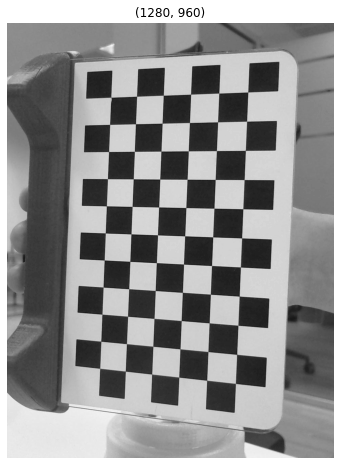

In [78]:
img = cv2.imread("dataset/frame0.jpg", 0)

plt.subplots(1,1,figsize=(8,8))
plt.imshow(img, cmap="gray")
plt.title(f"{img.shape}")
plt.axis('off');

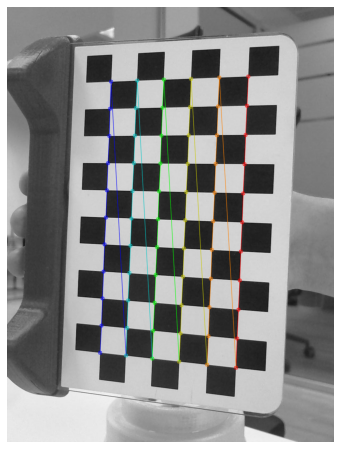

In [79]:
# Pattern parameters
rows = 6
columns = 11
square_width = 13

# Convert image to 1 channel
# gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(
    img, 
    (columns, rows), 
    flags=cv2.CALIB_CB_FAST_CHECK
)

# Draw corners into image
image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.drawChessboardCorners(image, (columns, rows), corners, ret)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplots(1,1,figsize=(8,8))
plt.imshow(image, cmap="gray")
plt.axis('off');

In [80]:
# Compute object points
objp = np.zeros((rows * columns, 3), np.float32)
objp[:, :2] = np.mgrid[0:columns, 0:rows].T.reshape(-1, 2)
objp *= square_width

# Camera calibration results
camera_matrix = np.array([[1430, 0, 480],[0, 1430, 640],[0, 0, 1]], dtype=np.float)
distortion_coefficients = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float)

# Compute pose
ret, rvecs, tvecs = cv2.solvePnP(
    objp, 
    corners, 
    camera_matrix, 
    distortion_coefficients)

if ret:
    R = cv2.Rodrigues(rvecs)[0]
    t = tvecs.T[0]
    n = R.T[2]
    d = np.dot(n, t)
    print(f"\nRotation matrix\n\n{R}\n")
    print(f"\nTranslation vector\n\n{t} mm\n")
    print(f"\nPlane normal\n\n{n}\n")
    print(f"\nPlane distance\n\n{d} mm\n")


Rotation matrix

[[-0.04080699 -0.96674275  0.25247425]
 [ 0.99916456 -0.0400462   0.00815342]
 [ 0.00222838  0.25259604  0.96756926]]


Translation vector

[ 34.44751347 -65.92659259 216.54402855] mm


Plane normal

[0.25247425 0.00815342 0.96756926]


Plane distance

217.68092893591555 mm



## Calculating Euler Angles

Euler angles are non-unique definitions of the orientation of a body (typically something like an airplane) relative to a fixed set of *global* (non-moving) axes. The definitions for roll, pitch, and yaw are shown below.

![](pyr.png)

The goal here is to calculate roll, pitch, and yaw and then draw it on the image for reference.

![](pattern_pose.png)

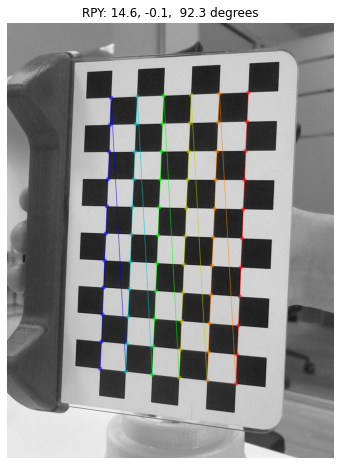

In [87]:
# R321
roll = atan2(R[2,1], R[2,2])*180/pi
pitch = -asin(R[2,0])*180/pi
yaw = atan2(R[1,0], R[0,0])*180/pi

plt.subplots(1,1,figsize=(8,8))
plt.imshow(image, cmap="gray")
plt.title(f"RPY: {roll:0.1f}, {pitch:0.1f}, {yaw: 0.1f} degrees")
plt.axis('off');

In [94]:
def draw(image, corners, imgpts, thick=5):
    img = image.copy()
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), thick)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), thick)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), thick)
    return img

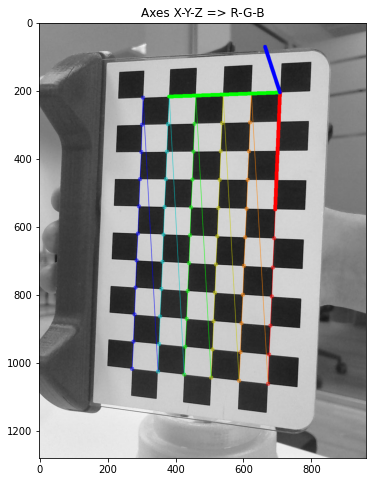

In [95]:
# set the axes size as a function of the marker's 
# square size and project onto image space
s = 4*square_width
axis = np.float32([[s,0,0], [0,s,0], [0,0,-s]]).reshape(-1,3)
imgpts, jac = cv2.projectPoints(
    axis, 
    rvecs, 
    tvecs, 
    camera_matrix, 
    distortion_coefficients
)

aimg = draw(image,corners.astype(int),imgpts.astype(int),10)

# The x and y axes should lie on the surface of the image
# while the x axis is into the chessboard
plt.subplots(1,1,figsize=(8,8))
plt.title("Axes X-Y-Z => R-G-B")
plt.imshow(aimg);

# References

- github: [3D Scan Science](https://github.com/Jesus89/3DScanScience)
- OpenCV Docs [pose](https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html)
- OpenCV Docs [solvePnP](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga549c2075fac14829ff4a58bc931c033d)
- wikipedia: [Rodriques rotations](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula)
- wikipedia: [axis angle representation](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation)

# Appedix: Rodrigues to Rotation Matrix

The equation from above again is:

$$
R = I + (sin \theta) K + (1-cos \theta) K^2
$$

In [127]:
def skew(x):
    return np.array([
        [0.0, -x[2], x[1]],
        [x[2], 0.0, -x[0]],
        [-x[1], x[0], 0.0]
    ])

rr, _ = cv2.Rodrigues(rvecs)
print("cv2.Rodrigues:\n", rr, "\n\n")

r = rvecs.ravel()
theta = norm(r)
e = r/t
k = skew(e)
rot = np.eye(3) + sin(theta) * k + (1-cos(theta)) * k@k
print("wikipedia:\n", rot)

cv2.Rodrigues:
 [[-0.04080699 -0.96674275  0.25247425]
 [ 0.99916456 -0.0400462   0.00815342]
 [ 0.00222838  0.25259604  0.96756926]] 


wikipedia:
 [[-0.04080699 -0.96674275  0.25247425]
 [ 0.99916456 -0.0400462   0.00815342]
 [ 0.00222838  0.25259604  0.96756926]]
